In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [4]:
os.listdir('/HAR/Human Action Recognition/HAR_')

['HAR_calling',
 'HAR_hugging',
 'HAR_laughing',
 'HAR_texting',
 'HAR_using_laptop',
 'HAR_clapping',
 'HAR_drinking',
 'HAR_sleeping',
 'HAR_eating',
 'HAR_sitting',
 'HAR_running',
 'HAR_listening_to_music',
 'HAR_dancing',
 'HAR_cycling',
 'HAR_fighting']

In [6]:
train_dataset_path = 'HAR/Human Action Recognition/HAR_'


In [7]:
train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [8]:
train_dataset = torchvision.datasets.ImageFolder(root= train_dataset_path, transform= train_transforms)

In [9]:
train_loader= torch.utils.data.DataLoader(dataset= train_dataset, batch_size=32, shuffle=False)

In [10]:
import torch

def get_mean_and_std(loader):
    
    channel_sum, channel_squared_sum, num_batches= 0,0,0

    for images, _ in loader:
        channel_sum += torch.mean(images, dim=[0,2,3])
        channel_squared_sum += torch.mean(images**2 , dim=[0,2,3])
        num_batches+=1
    
    mean = channel_sum/num_batches
    std= (channel_squared_sum/num_batches - mean **2)** 0.5

    return mean, std


In [11]:
get_mean_and_std(train_loader)

(tensor([0.5711, 0.5359, 0.5053]), tensor([0.3024, 0.2991, 0.3060]))

In [12]:
train_dataset_path = 'HAR/Human Action Recognition/HAR_'
test_dataset_path ='HAR/Human Action Recognition/Validation'

In [13]:
mean=[0.5711, 0.5359, 0.5053]
std = [0.3024, 0.2991, 0.3060]
train_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
    ]

)

In [14]:
train_dataset = torchvision.datasets.ImageFolder(root= train_dataset_path, transform= train_transforms)
test_dataset =torchvision.datasets.ImageFolder(root=test_dataset_path, transform=train_transforms)

In [15]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    images , labels=batch

    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels', labels)
    

labels tensor([ 8,  2, 10,  7, 10,  5])


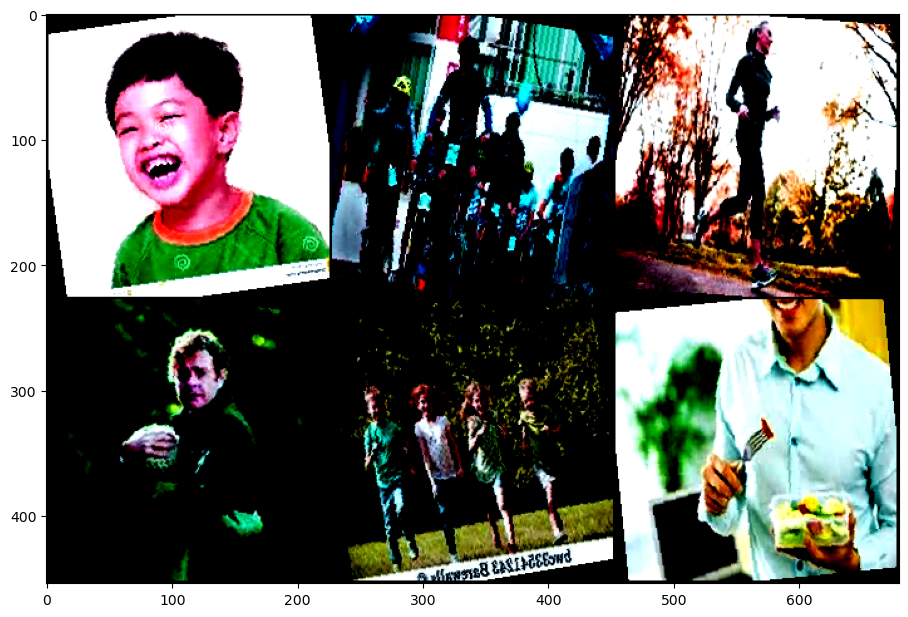

In [16]:
show_transformed_images(train_dataset)

In [17]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
def set_device():
    if torch.cuda.is_available():
        dev= "cuda:0"
    else:
        dev="cpu"
    return torch.device(dev)

In [19]:
device=set_device()
print(device)

cuda:0


In [20]:
import torch

def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc=0
    for epoch in range(n_epochs):
        print("Epoch number %d" % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for data in train_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)

            optimizer.zero_grad()

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        # Indentation corrected to calculate metrics within the epoch loop
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.00 * running_correct / total

        print("         - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch Loss: %.3f"
              % (running_correct, total, epoch_acc, epoch_loss))

        test_dataset_acc= evaluate_model_on_test_set(model, test_loader)
        if(test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model,epoch,optimizer,best_acc)
    print("Finished")
    return model


In [21]:
def evaluate_model_on_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()

    with torch.no_grad():
        for data in test_loader:
            images, labels= data
            images = images.to(device)
            labels = labels.to(device)
            total  += labels.size(0)

            outputs = model(images)

            _, predicted = torch.max(outputs.data, 1)
            predicted_correctly_on_epoch +=(predicted == labels).sum().item()

        epoch_acc = 100.0 * predicted_correctly_on_epoch/total
        print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
          %(predicted_correctly_on_epoch, total, epoch_acc))
        
        return epoch_acc 

In [22]:
def save_checkpoint(model,epoch,optimizer,best_acc):
    state = {
        'epoch' : epoch + 1,
        'model' : model.state_dict(),
        'Best Accuracy' : best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [24]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet101_model = models.resnet101(pretrained = True)
num_ftrs = resnet101_model.fc.in_features
number_of_classes = 15
resnet101_model.fc= nn.Linear(num_ftrs, number_of_classes)
device = set_device()
resnet101_model = resnet101_model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(resnet101_model.parameters(), lr=0.01, momentum= 0.9, weight_decay=0.003)

In [25]:
train_nn(resnet101_model, train_loader, test_loader,loss_fn, optimizer, 50)

Epoch number 1
         - Training dataset. Got 4950 out of 10080 images correctly (49.107%). Epoch Loss: 1.657
    - Testing dataset. Got 1358 out of 2520 images correctly (53.889%)
Epoch number 2
         - Training dataset. Got 6492 out of 10080 images correctly (64.405%). Epoch Loss: 1.144
    - Testing dataset. Got 1425 out of 2520 images correctly (56.548%)
Epoch number 3
         - Training dataset. Got 6813 out of 10080 images correctly (67.589%). Epoch Loss: 1.027
    - Testing dataset. Got 1265 out of 2520 images correctly (50.198%)
Epoch number 4
         - Training dataset. Got 7075 out of 10080 images correctly (70.188%). Epoch Loss: 0.933
    - Testing dataset. Got 1477 out of 2520 images correctly (58.611%)
Epoch number 5
         - Training dataset. Got 7096 out of 10080 images correctly (70.397%). Epoch Loss: 0.919
    - Testing dataset. Got 1469 out of 2520 images correctly (58.294%)
Epoch number 6
         - Training dataset. Got 7125 out of 10080 images correctly (7

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 